# Hi
- I'm Adam.
    - Super brief bio
        - Links
    - Numerous RL projects in the past.
        - Included in my public repositories on GH.

<a id="overview"></a>

Everyone in this room can be conceptualized as a series of records that have, do, or will exist.
- We begin with a birth certificate ...
- ... and end with a death certificate.
- In between, there will be medical records, school records, marriage records, bank records, arrest records, etc.

Imagine what we could learn about ourselves by integrating all of that information, from all of those different sources, into one single, cohesive story.

And, if data were perfectly clean, this would be a simple `JOIN` operation.
- <b>But it's not.</b> Which is why we need techniques to integrate inconsistent data.
- Those techniques will be the focus of this talk.

## Quick example

- Public health example: Joining hospital records to birth certificates.
    - What problems would occur?
        1. People change
            - Names, addresses, ...
        2. People make mistakes
            - Typos, spelling errors, nicknames, abbreviations, ...
        3. People lie
            - Age, weight, neighborhood, ...

<a id="areas"></a>
## Application areas
Data matching is not new -- well before computers, we needed to match records belonging to the same individual.
- National census
    - Governments around the world rely on census data to allocate resources appropriately.
    - RL plays an important role in improving the quality and accuracy of census data.
    - The U.S. Census Bureau has played a major role in the development of RL techniques for several decades.

<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Seal_of_the_United_States_Census_Bureau.svg/200px-Seal_of_the_United_States_Census_Bureau.svg.png" alt="Census Bureau seal" height="140" width="140">    

- Medicine and public health 
    - (historically referred to as _medical_ record linkage)
    - Simply consider all of the doctors, hospitals, insurance companies, and pharmacies you've interacted with and it becomes obvious why medical records are another major RL application area.
    - In addition, _longitudinally-matched records_ can provide novel insights into health outcomes, as in the example given previously.
    
<p><img width="256" alt="Seattle physician with patient 1999" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Seattle_physician_with_patient_1999.jpg/256px-Seattle_physician_with_patient_1999.jpg"></a>

- Customer records
    - In order to effectively target their customers, businesses need to minimize the redundancy that tends to occur as a result of changes in name, address, etc.
    - This requires businesses to periodically remove redundant records, in order to maintain an accurate record of their customer base (often a main source of revenue) and reach those customers effectively.
    
<img src="https://upload.wikimedia.org/wikipedia/en/7/78/DB-database-icon.png" alt="DB-database-icon.png" width="200"></a>

- Genealogy
    - Given that more than 10% of men and women were named 'John' and 'Mary' in nineteenth century England, it becomes obvious why RL is an invaluable tool for genealogical databases, some of which are now a billion-dollar industry.
    - [LDS have spent a lot of $$$ and published a few papers on RL]
    
<img src="https://upload.wikimedia.org/wikipedia/commons/a/a8/1900_census_Kershaw_Lindauer.gif" alt="1900 census Kershaw Lindauer.gif" height="480" width="456">

<br>
<div style="text-align: right">1900 US Census, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=11768459">Link</a></div>

<a id="why"></a>
## Why do I care?

- As a society, we are producing more data than ever before. In order to make use of it, we need intelligent solutions to integrate data from disparate sources.
- Such tools play an important role in both data mining _and_ data warehousing -- using RL, we can not only improve the quality (and statistical power) of our data, but also reveal relationships not contained within any single database.

# [Overview](#overview)

## [Quick example](#example)

## [Application areas](#areas)

## [Why do I care?](#why)

# [Challenges](#challenges)
- First, I want to make you aware of the specific, unique challenges involved with RL, so you can better appreciate why the approach includes the steps it does.

## [Missing unique identifiers](#unique)
- Records on people or businesses is often very 'messy' with inconsistent formatting from one database to the next.
- This makes finding unique matches unlikely. Instead, for each record there is a handful of plausible matches, each matching to a varying degree.
    
## [Computational complexity](#complexity)
- Because any time you're working with Cartesian products you are working with a quadratic time complexity ($0(n^2)$), intelligent sub-setting of your data (via 'blocking') becomes essential.

## [Lack of training labels](#labels)
- Due to the expense of hand-labeling training data, we often need to use an unsupervised approach to RL.

## [Privacy](#privacy)
- In spite of our attempts to keep nice, complete databases, people still demand privacy (go figure).
- As a result, fields that include identifying information are often removed or encrypted, adding to the challenge of our task.
    

# [Classic record linkage](#classic)
- Second, I want to give you a snapshot of the classic record linkage approach which will include:

## [Pre-processing](#pre)
- Normalization of undesired variation
- Ensuring consistent formatting

## [Indexing (blocking)](#blocking)
- To reduce the complexity of the task by beginning with smaller subsets of data that are very likely to contain matching records.

## [Comparison and classification](#classification)
- Classification of each record pair into 'matches' and 'non-matches' can be performed using either a deterministic (rule-based) or probabilistic (model-based) approach.
- In the probabilistic approach, comparisons between pairs are broken down into feature vectors summarizing their agreement along multiple dimensions, both simple (e.g. name, address, D.O.B.) and complex (e.g. distance between addresses).
- With those feature vectors, we can apply any one of hundreds of different classification models to attempt to predict whether those records are 'matches' or not.

## [Evaluation](#evaluation)
- Evaluation involves determining how successful the linkage was, in terms of correctly identified pairs.
- This can be complicated by the class imbalance between 'match' vs 'non-match' samples.

# [Demo](#demo)

## [Comparing the performance of classifiers](#comparing)

### [Supervised classifiers](#supervised)

### [Unsupervised classifiers](#unsupervised)



<a id="challenges"></a>
# Challenges

<a id="unique"></a>
## Missing unique identifiers

In all of these cases, the challenge that we have to overcome is missing a unique identifier for the entities we are matching.
- For example, if we had perfectly accurate social security numbers for each record, the task is reduced to a straight-forward join of two databases.
- This is often not the case for multiple reasons:
    1. accurate record keeping is hard
    2. privacy is usually a concern (in some countries use of such identifiers is illegal).
- As such, in order to match records across databases, we must use common attributes shared by both databases.
    - e.g. Name, address, phone number, age
- The quality of data points such as these are notoriously low for reasons described earlier.

<a id="complexity"></a>
## Computational complexity
- As a naive approach, one might try comparing each record in one database, to each record in the other, to determine if each pair under consideration might be a match.
- The computational complexity of such an approach, however, grows quadratically ($O(N²)$) with the size of the smaller database.
- As we'll see, some nice tricks exist to reduce the size of the problem substantially.

<a id="labels"></a>
## Lack of training labels
- In the typical (supervised) machine learning approach, labeled training data is used as feedback by a statistical model during the process of training. 
- In some cases, the there is no training data that tells us if two records correspond to the same individual or not.
- This can make the evaluation of the model's matches especially challenging.

<a id="privacy"></a>
## Privacy
- Given that these records often contain sensitive personal information (such as medical/employment records), special attention must be paid to preserving this privacy via _'de-identification'_.
- This is especially important for academic or medical researchers using HIPAA-protected datasets for research use.

<a id="classic"></a>
# Classic record linkage
I will use 'record linkage' to refer to both the matching of records across two (or more) databases.
- This can also include the special case of _'de-duplication'_, which simply involves using the same approach* to find duplicate records in _the same_ database.

<div style="text-align: right">*De-duplication can sometimes involve matching more than 2 records within a database.</div>

Most commonly, each record refers to a real-live person* (shown below, in case you forgot).
<div style="text-align: right"><img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Akha_cropped_hires.JPG" alt="Akha cropped hires.JPG" width="200"></a><br><a href="https://en.wikipedia.org/wiki/User:Weltenbummler84" class="extiw" title="en:User:Weltenbummler84">Image source</a></div>

- Customers in a business database
- Constituents in a government database
- Patients in a hospital database
<div style="text-align: right">*Sometimes the entity to be matched is a business, or some other object.</div>

<img src="assets/rl_pipeline_figure.png" alt="RL pipeline figure" width="456">

<a id="pre"></a>
## Pre-processing

<img src="assets/record_examples.png" alt="Example records" width="700">

Records from different databases often vary wildly in their formatting conventions.
- As a result, it falls to use to ensure that the data we want to compare has been properly cleaned and standardized.
- Any inconsistencies _must_ be resolved for successful linkage.

Although the potential problems that may need to be addressed during pre-processing are too numerous to list -- we can refine the process into three major steps:
1. Removing undesired characters/words
    - Non-alphanumeric characters
    - In some cases, removing irrelevant words (_stop words_) is useful.
2. Standardize abbreviations and correct typos
    - Use hash mapping to reduce the variation of equivalent values.
3. Parsing input to create new variables (feature engineering)
    - As we'll see, parsing our raw data into it's component elements allows us to model each of them individually, often resulting in a better performing model _and_ a greater ability to make inferences about which variables are most important during classification.   

> Regardless of the specific pre-processing steps that you perform - <b>It is important to not over-write the original, raw data!</b>
> - Otherwise, there is no guarantee that it can be recovered after being transformed.
> - Later, different pre-processing may be desired.
> Ideally, new copies of the data are created after each major transformation.

%%% Names?
% - First, middle, family name is an Anglo-Saxon convention.
% - How they change, or stay the same, depends on your culture.

%%% FILL OUT

- Handling missing values
- Handling outliers
---
- Filtering Characters/Tokens
- Standardization
    - Phonetic encoding
        - Used to convert words into the way they are spoken, rather than the way they are spelled, since the latter can be more culturally-specific.
        - Example: Soundex
- Segmentation
    - Rule-based
    - Statistical (HMM)

Ideally, after pre-processing, those same records would look something like this below.

<img src="assets/record_clean.png" alt="Example records" width="800">

- Our data now contains all attributes from both databases.
- Content has been standardized.
- Contradicting fields have been corrected
- Abbreviations have been expanded




<a id="blocking"></a>
## Indexing (blocking)
Now, we are ready to compare our records to look for a match.
- But, if we are dealing with typical databases containing, say, a million or more records -- clearly we are not capable of comparing one trillion record pairs in a reasonable* time span.

<div style="text-align: right">*Ideally, we're talking minutes to hours, not days or weeks.</div>

Like any good algorithm designer, though, we can start to think about where we can save ourselves from doing work.
- The vast majority of record comparisons will be non-matches.
- Especially so for records that are dis-similar along particular dimensions.

> For example, while matching record pairs may sometimes contain different phone numbers, they will almost never contain different genders. 
> - As a result, we can reduce the complexity of our algorithm substantially by simply comparing only records matching on gender.
>
> <img src="assets/blocking.png" alt="Blocking example" width="800">
>

<b><i>Blocking</i></b>, is a similar approach to indexing, which relies on a small number of such features to reduce the number of comparisons.
- 'zip code' and 'phonetically-encoded surname' are two such examples.
- For greater improvements in performance, it is common to block using <i>multiple</i> variables, in succession.

> <b>Warning!</b>: This approach does, however, sometimes miss certain matches that may, for example, contain a typo in one of the <i>blocking keys</i>.
> - In the example above, the record would not have any chance of being matched in the event that gender changed or was entered incorrectly.
> - This highlights the need for careful selection of blocking criteria.

%%% FILL OUT

- Defining blocking keys
    - Data quality/consistency
    - Number vs. size of blocks
    - Blocking keys can be optimized just like any other hyper-parameter.
- Blocking is also an opportunity to leverage parallel processing approaches to decrease processing time, when that is applicable.

<a id="classification"></a>
## Comparison and classification

Next, the similarity between our candidate pairs is calculated by comparing several record attributes.
- This can range from simple numeric comparisons, like the difference between ages of each record, to more complex comparison functions, like 'fuzzy' string matching. 
- It also a good idea to include cross comparisons. 
    - For example, in certain cultures, first and last name are sometimes used in the reverse order. 
    - So, including a comparison of first name with last name can catch instances such as these.
- A few examples of such comparisons are shown below.

<img src="assets/record_comparison.png" alt="Record comparison" width="600">

The result is a <b>comparison vector</b> for each pair.
- We calculated similarity using approximate comparisons for strings, edit distance for numbers, and equivalence for Booleans.
- This <i>feature vector</i> is what we use for classification.

%%% Traditional record linkage entails using a probabilistic approach equivalent to a Naive Bayes classifier.
% - The advantages of this approach, and perhaps the reason for its overwhelming popularity, are...

Using our comparison vector, we can no classify each record pair as either a 'match' or 'non-match'.
- Given that this operation is performed on each record pair, <i>independently</i> of all other pairs, a given record may classify as a match for more than one record.

%%% Put munkres here?

<a id="evaluation"></a>
## Evaluation
Of course, in order to evaluate our algorithm, we would prefer to have access to labeled data that can be used for validation.
- This would contain the true match status of all possible matches.

<b>Unfortunately</b>, obtaining ground-truth data is very often not possible and so other solutions must be applied.

%%% Discuss unsupervised approaches here?

In the event we <i>do</i> have labeled data, we must still contend with a formidable class imbalance, between matches and non-matches.
- As a result, appropriate classification metrics must be applied.
    - Accuracy, for example, can grow very high by classifying everything as 'non-match'.

In this talk, we'll focus on classifying record pairs as either a 'match' or 'non-match'.
- However, a third classification can sometimes be useful -- 'possible match'.
- These records can then undergo clerical review, and the classified records can then be added to the training data for your model, thus improving your classifier.
- This is very often not feasible.

<a id="demo"></a>
# Demo

For this demo, we'll use [`recordlinkage`](https://recordlinkage.readthedocs.io/en/latest/about.html), a very popular and well-maintained Record Linkage toolkit for Python.
- %%DESCRIBE DATA%%

<a id="comparing"></a>
## Comparing the performance of classifiers

Inspired by:
https://recordlinkage.readthedocs.io/en/latest/notebooks/classifiers.html

https://recordlinkage.readthedocs.io/en/latest/notebooks/link_two_dataframes.html

https://recordlinkage.readthedocs.io/en/latest/ref-classifiers.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# record linkage
import recordlinkage as rl
from recordlinkage.datasets import load_febrl4

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
# load demo data (with true labels)
dfA, dfB, true_links = load_febrl4(return_links=True)

In [3]:
# check out dataframe A
dfA.sample(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2973-org,thomas,brain,22,holmes crescent,anstee court,hackham west,3465,vic,19711119,6218887
rec-4433-org,lily,matthews,57,captain cook crescent,NaN,matraville,2774,vic,19420708,9637615
rec-2141-org,alexandra,meixner,42,mannheim street,casablanca,st albans,2913,sa,19030525,3838784


In [4]:
# check out dataframe B
dfB.sample(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2592-dup-0,flynh,banham,164,starke street,stonehuose,carlingford,2444,sa,19890221,3189743
rec-343-dup-0,steaven,green,9,duigan place,dunbarh ei ghts,pennant hills,7010,qld,19760329,8403741
rec-1201-dup-0,jayden,blake,3,kemsley place,mlc ceyntre,kariong,2210,qld,19020112,7106228


In [5]:
# indexing step
indexer = rl.Index()
indexer.block('given_name')
candidate_links = indexer.index(dfA, dfB)

# comparison step
compare_cl = rl.Compare()

# compare_cl.exact('given_name', 'given_name', label='given_name')
# compare_cl.string('surname', 'surname', method='jarowinkler', threshold=0.85, label='surname')
# compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth')
compare_cl.exact('suburb', 'suburb', label='suburb')
compare_cl.exact('state', 'state', label='state')
compare_cl.string('address_1', 'address_1', threshold=0.85, label='address_1')

# generate feature array
features = compare_cl.compute(candidate_links, dfA, dfB)

# classification step: simple threshold 
matches = features[features.sum(axis=1) > 3]
print(len(matches))

0


In [6]:
# we'll compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

%% SHOW EXAMPLES OF MATCHES AND NON-MATCHES

<a id="supervised"></a>
### Supervised classifiers

https://recordlinkage.readthedocs.io/en/latest/notebooks/classifiers.html#Supervised-learning

In [7]:
labels = [element in true_links for element in features.index.to_list()]

# Create a training and test set
X_train, X_test, y_train, y_test  = train_test_split(features, labels, test_size=0.25)

#### Logistic regression

In [8]:
def evaluate_model(model):
    clf = model.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(np.array([['tn', 'fp'], ['fn', 'tp']]))
    print(confusion_matrix(y_test, predictions))
    print()
    print(f"F1 score: {f1_score(y_test, predictions, average='macro')}")
    return predictions

In [9]:
predictions_logreg = evaluate_model(LogisticRegression(solver='lbfgs', random_state=0))

[['tn' 'fp']
 ['fn' 'tp']]
[[18503    15]
 [   32   763]]

F1 score: 0.9844261675029886


In [10]:
k = 'logreg'
fpr[k], tpr[k], _ = roc_curve(y_test, predictions_logreg)
roc_auc[k] = auc(fpr[k], tpr[k])

#### Naive Bayes classifier

In [11]:
predictions_nb = evaluate_model(MultinomialNB())

[['tn' 'fp']
 ['fn' 'tp']]
[[18495    23]
 [   27   768]]

F1 score: 0.9835621283966891


#### Support Vector Machine

In [12]:
predictions_svc = evaluate_model(SVC(random_state=0))

[['tn' 'fp']
 ['fn' 'tp']]
[[18503    15]
 [   32   763]]

F1 score: 0.9844261675029886


<a id="unsupervised"></a>
### Unsupervised classifiers

https://recordlinkage.readthedocs.io/en/latest/notebooks/classifiers.html#Unsupervised-learning

#### K-means clustering

In [13]:
predictions_kmeans = evaluate_model(KMeans(n_clusters=2))

[['tn' 'fp']
 ['fn' 'tp']]
[[ 4072 14446]
 [  747    48]]

F1 score: 0.17762637841707318


#### Expectation/Conditional Maximization Algorithm

In [14]:
predictions_ecm = evaluate_model(GaussianMixture(n_components=2))

[['tn' 'fp']
 ['fn' 'tp']]
[[18495    23]
 [   27   768]]

F1 score: 0.9835621283966891


%% [CREATE MULTI-CLASS ROC CURVE TO FINISH 'ER OFF!!!!!]

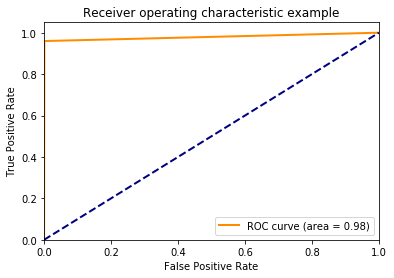

In [15]:
lw = 2
plt.plot(fpr[k], tpr[k], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[k])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
# # Get the true pairs for each set
# y_train = X_train.index & true_links
# y_test = X_test.index & true_links

In [17]:
# # train logistic regression classifier
# logreg = rl.LogisticRegressionClassifier()

# # train classifier
# logreg.fit(X_train, y_train)
# print ("Intercept: ", logreg.intercept)
# print ("Coefficients: ", logreg.coefficients)

# # predict match status for record pairs
# predictions_logreg = logreg.predict(X_test)

# print(rl.confusion_matrix(y_test, predictions_logreg, len(y_test)))

# # The F-score for this prediction is
# print(rl.fscore(true_links, predictions_logreg))

In [18]:
# # train Naive Bayes classifier
# nb = rl.NaiveBayesClassifier(binarize=0.3)
# nb.fit(X_train, y_train)

# # predict match status for record pairs
# predictions_nb = nb.predict(X_test)

# rl.confusion_matrix(y_test, predictions_nb, len(y_test))

# rl.fscore(true_links, predictions_nb)

In [19]:
# # train svm classifier
# svm = rl.SVMClassifier()
# svm.fit(X_train, y_train)

# # predict match status for record pairs
# predictions_svm = svm.predict(X_test)

# rl.confusion_matrix(y_test, predictions_svm, len(y_test))

# rl.fscore(true_links, predictions_svm)

In [20]:
# # train kmeans classifier
# kmeans = rl.KMeansClassifier()
# kmeans.fit(X_train)

# # predict match status for record pairs
# predictions_kmeans = kmeans.predict(X_test)

# rl.confusion_matrix(y_test, predictions_kmeans, len(y_test))

# rl.fscore(true_links, predictions_kmeans)

In [21]:
# # train ecm classifier
# ecm = rl.ECMClassifier(binarize=0.8)
# ecm.fit(X_train)

# # predict match status for record pairs
# predictions_ecm = ecm.predict(X_test)

# rl.confusion_matrix(y_test, predictions_ecm, len(y_test))

# rl.fscore(true_links, predictions_ecm)